In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [109]:
new_df = pd.read_csv('sentiment_scored_.csv')

In [110]:
new_df = new_df.sort_values(by='timestamp')
new_df.drop(columns=['Unnamed: 0'],inplace=True)
new_df.head()

,rating,text,timestamp,rob_neg,rob_neu,rob_pos
11566,4,Easy to use. Non invasive. Vibrates with resul...,2018-05-11 17:21:49.173,0.013828,0.014668,0.971504
15082,5,This is the easiest thermometer that gives the...,2018-05-12 18:36:23.059,0.014745,0.014590,0.970665
1903,5,Easy to use. Easy to read display. Light weigh...,2018-05-13 00:28:58.218,0.016857,0.024825,0.958318
15180,4,I like that you don't touch the skin; that it ...,2018-05-24 16:19:08.822,0.082151,0.121618,0.796231
15771,4,My only complaint is that it does not work wit...,2018-05-24 17:02:23.110,0.057362,0.056420,0.886218


In [111]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], errors='coerce')

In [112]:
new_df['moving_average_neg'] = new_df['rob_neg'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_neu'] = new_df['rob_neu'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_pos'] = new_df['rob_pos'].rolling(window=30, min_periods=1).mean()

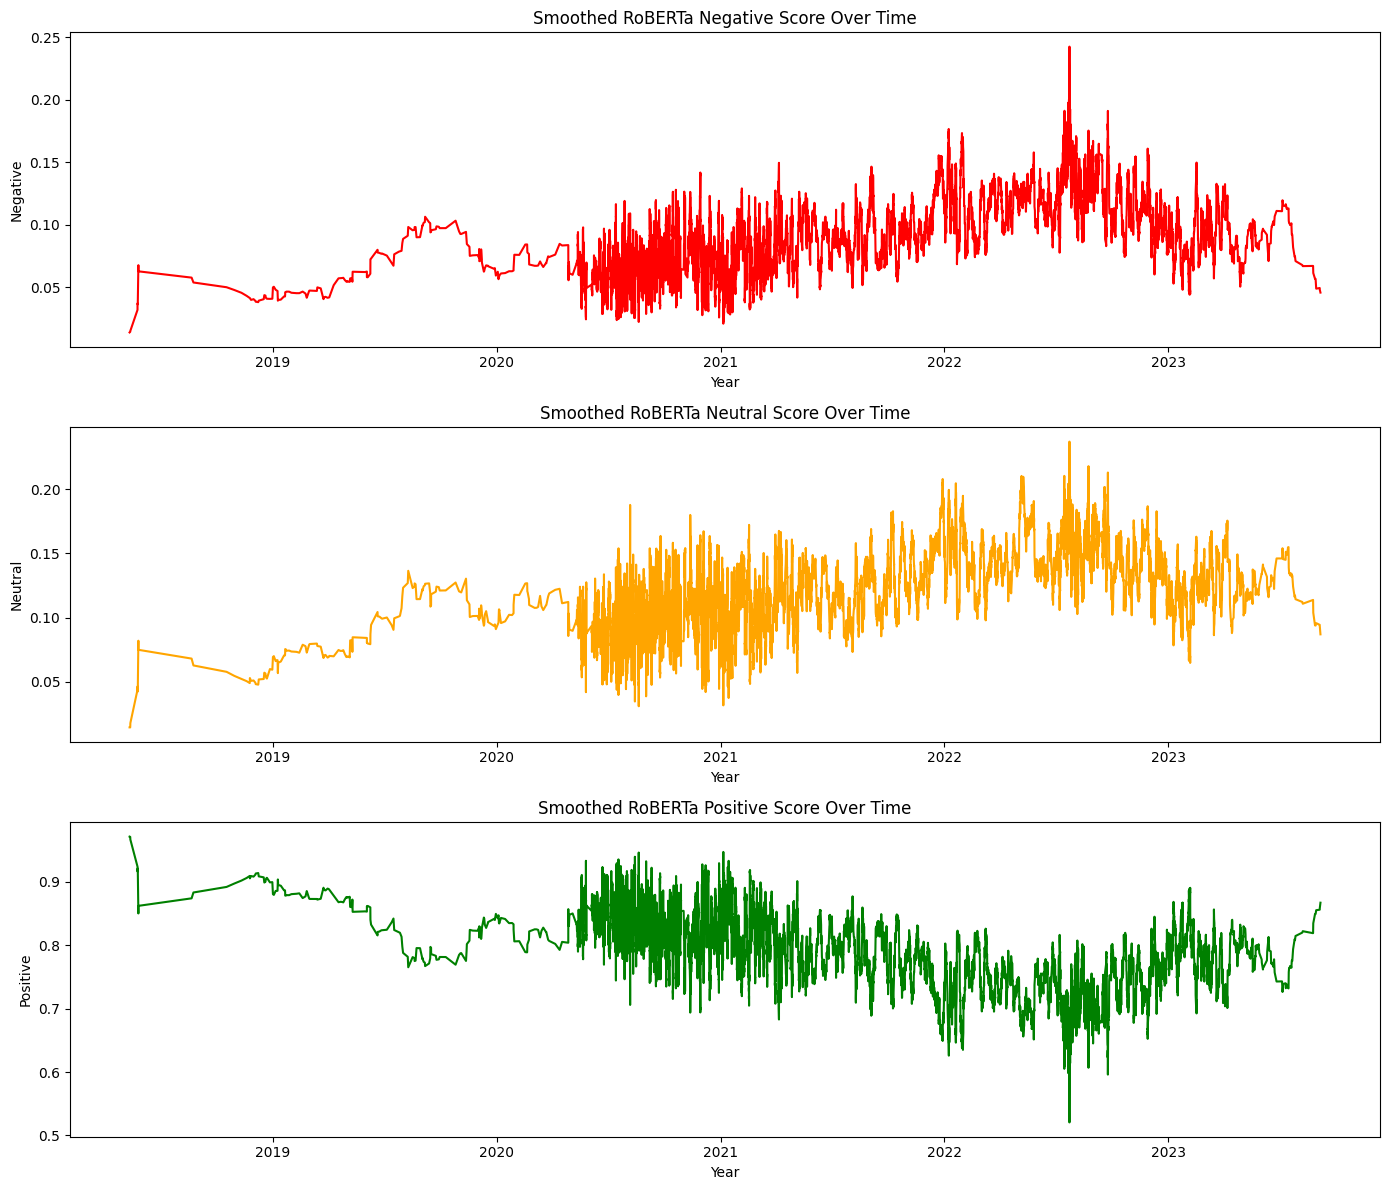

In [113]:
fig, arr = plt.subplots(3, 1, figsize=(14, 12))

arr[0].plot(new_df['timestamp'], new_df['moving_average_neg'], color='red')
arr[0].set_title("Smoothed RoBERTa Negative Score Over Time")
arr[0].set_ylabel("Negative")
arr[0].set_xlabel("Year")

arr[1].plot(new_df['timestamp'], new_df['moving_average_neu'], color='orange')
arr[1].set_title("Smoothed RoBERTa Neutral Score Over Time")
arr[1].set_ylabel("Neutral")
arr[1].set_xlabel("Year")

arr[2].plot(new_df['timestamp'], new_df['moving_average_pos'], color='green')
arr[2].set_title("Smoothed RoBERTa Positive Score Over Time")
arr[2].set_ylabel("Positive")
arr[2].set_xlabel("Year")

plt.tight_layout()
plt.show()


In [114]:
new_df.head()

,rating,text,timestamp,rob_neg,rob_neu,rob_pos,moving_average_neg,moving_average_neu,moving_average_pos
11566,4,Easy to use. Non invasive. Vibrates with resul...,2018-05-11 17:21:49.173,0.013828,0.014668,0.971504,0.013828,0.014668,0.971504
15082,5,This is the easiest thermometer that gives the...,2018-05-12 18:36:23.059,0.014745,0.014590,0.970665,0.014287,0.014629,0.971084
1903,5,Easy to use. Easy to read display. Light weigh...,2018-05-13 00:28:58.218,0.016857,0.024825,0.958318,0.015144,0.018028,0.966829
15180,4,I like that you don't touch the skin; that it ...,2018-05-24 16:19:08.822,0.082151,0.121618,0.796231,0.031895,0.043925,0.924179
15771,4,My only complaint is that it does not work wit...,2018-05-24 17:02:23.110,0.057362,0.056420,0.886218,0.036989,0.046424,0.916587


# Negative Sentiment

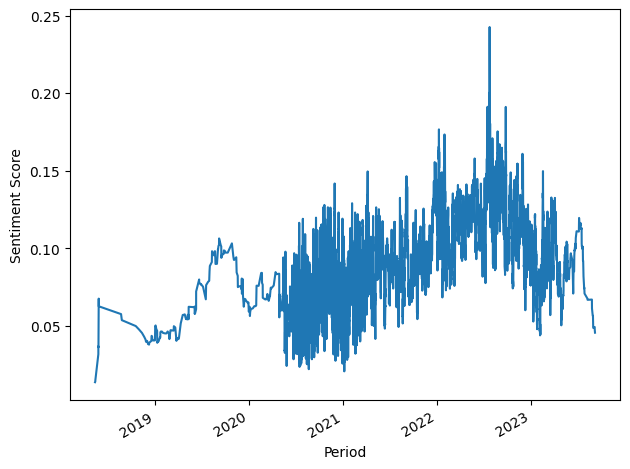

In [115]:
fig, ax = plt.subplots()

ax.plot(new_df['timestamp'], new_df['moving_average_neg'])
ax.set_xlabel('Period')
ax.set_ylabel('Sentiment Score')

fig.autofmt_xdate()
plt.tight_layout()

In [116]:
ad_fuller_result = adfuller(new_df['moving_average_neg'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.4086474699784395
p-value: 1.9151155066026338e-08


In [117]:
len(new_df['moving_average_neg'])

16857

In [118]:
0.8*len(new_df['moving_average_neg'])

13485.6

In [119]:
train = new_df[['timestamp', 'moving_average_neg']][:int(0.8 * len(new_df))]
test = new_df[['timestamp', 'moving_average_neg']][int(0.8 * len(new_df)):]

In [120]:
train.set_index('timestamp', inplace=True)
test.set_index('timestamp', inplace=True)

In [121]:
test

,moving_average_neg
timestamp,
2022-03-10 20:11:34.302,0.083570
2022-03-10 22:26:56.646,0.084208
2022-03-11 00:05:25.522,0.084013
2022-03-11 01:28:19.973,0.082424
2022-03-11 02:27:32.191,0.092467
...,...
2023-08-29 18:54:05.585,0.056659
2023-08-30 18:12:48.887,0.048862
2023-09-05 12:28:50.291,0.049378


In [122]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [123]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 0

order_list = list(product(ps, qs))

In [124]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",-110799.306738
1,"(3, 2)",-110737.892170
2,"(2, 2)",-110732.778792
3,"(2, 1)",-110730.688989
4,"(2, 3)",-110728.156237
5,"(1, 3)",-110725.373161
6,"(3, 0)",-110714.734870
7,"(1, 2)",-110713.108913
8,"(2, 0)",-110709.273815
9,"(1, 1)",-110708.427627


In [125]:
model = SARIMAX(train, order=(3,0,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     moving_average_neg   No. Observations:                13485
Model:               SARIMAX(3, 0, 3)   Log Likelihood               55406.653
Date:                Sat, 10 May 2025   AIC                        -110799.307
Time:                        19:40:00   BIC                        -110746.741
Sample:                             0   HQIC                       -110781.775
                              - 13485                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7665      0.082      9.325      0.000       0.605       0.928
ar.L2          0.9764      0.018     55.355      0.000       0.942       1.011
ar.L3         -0.7439      0.081     -9.149      0.0

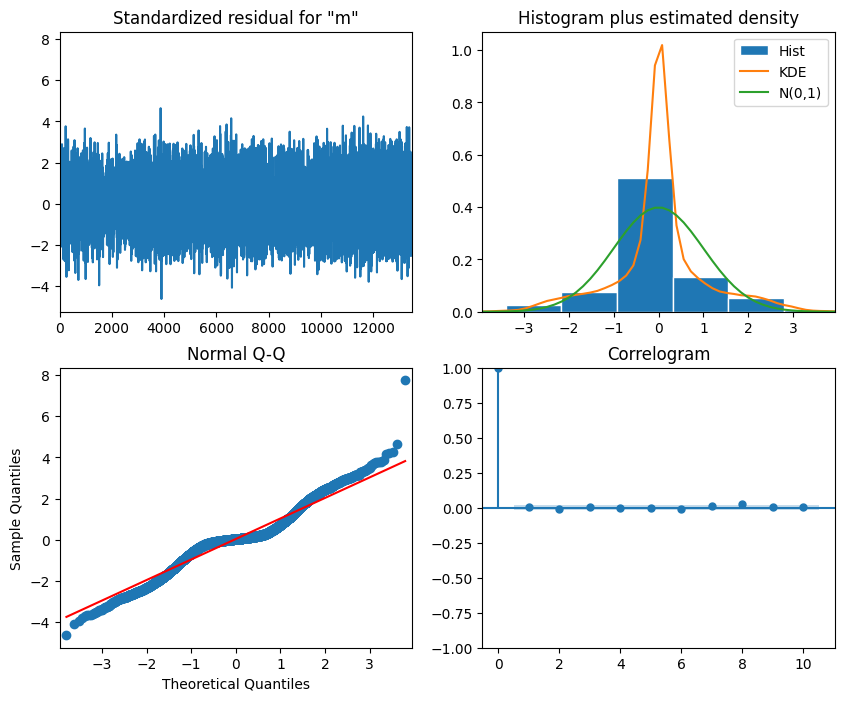

In [126]:
model_fit.plot_diagnostics(figsize=(10,8))

In [127]:
residuals = model_fit.resid

lbvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lbvalue

,lb_stat,lb_pvalue
1,0.228828,0.632394
2,0.957464,0.619569
3,1.712548,0.634148
4,1.906617,0.752929
5,1.992014,0.850249
6,2.890574,0.822450
7,4.537239,0.716229
8,11.536022,0.173137
9,11.842893,0.222312
10,12.140673,0.275752


In [128]:
len(train)

13485

In [129]:
len(test)

3372

In [130]:
13485+3372

16857

In [131]:
ARIMA_pred = model_fit.get_prediction(13485, 16856).predicted_mean

ARIMA_pred

,predicted_mean
13485,0.078714
13486,0.078657
13487,0.078370
13488,0.078320
13489,0.078043
...,...
16852,0.000104
16853,0.000104
16854,0.000103
16855,0.000103


In [132]:
pred = pd.DataFrame(ARIMA_pred)

In [139]:
df1 = test.reset_index(drop=True)
df2 = pred.reset_index(drop=True)

df1['predicted_mean'] = df2['predicted_mean'].values


In [144]:
df1

,moving_average_neg,predicted_mean
0,0.083570,0.078714
1,0.084208,0.078657
2,0.084013,0.078370
3,0.082424,0.078320
4,0.092467,0.078043
...,...,...
3367,0.056659,0.000104
3368,0.048862,0.000104
3369,0.049378,0.000103
3370,0.048050,0.000103


In [136]:
test

,moving_average_neg,ARIMA_pred
timestamp,,
2022-03-10 20:11:34.302,0.083570,0.000103
2022-03-10 22:26:56.646,0.084208,0.000103
2022-03-11 00:05:25.522,0.084013,0.000103
2022-03-11 01:28:19.973,0.082424,0.000103
2022-03-11 02:27:32.191,0.092467,0.000103
...,...,...
2023-08-29 18:54:05.585,0.056659,0.000103
2023-08-30 18:12:48.887,0.048862,0.000103
2023-09-05 12:28:50.291,0.049378,0.000103


In [147]:
df1

,moving_average_neg,predicted_mean
0,0.083570,0.078714
1,0.084208,0.078657
2,0.084013,0.078370
3,0.082424,0.078320
4,0.092467,0.078043
...,...,...
3367,0.056659,0.000104
3368,0.048862,0.000104
3369,0.049378,0.000103
3370,0.048050,0.000103


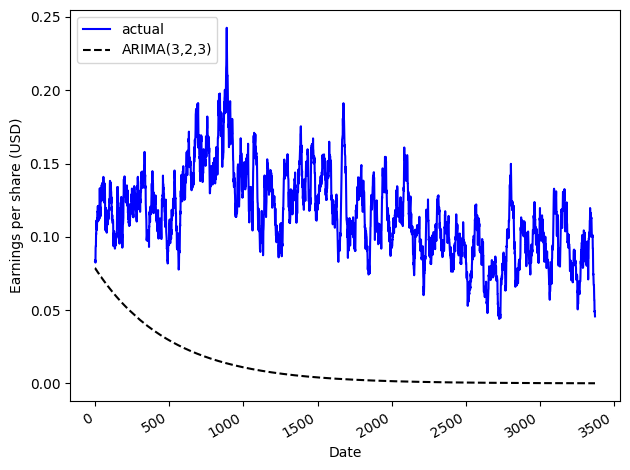

In [146]:
fig, ax = plt.subplots()

ax.plot(df1['moving_average_neg'], 'b-', label='actual')
ax.plot(df1['predicted_mean'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [148]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# True values and predicted values
y_true = df1['moving_average_neg']
y_pred = df1['predicted_mean']

# Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Display results
print(f"R² Score  : {r2:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"MSE       : {mse:.4f}")
print(f"RMSE      : {rmse:.4f}")


R² Score  : -13.2854
MAE       : 0.1038
MSE       : 0.0117
RMSE      : 0.1081


# Positive Sentiment

In [151]:
train = new_df[['timestamp', 'moving_average_pos']][:int(0.8 * len(new_df))]
test = new_df[['timestamp', 'moving_average_pos']][int(0.8 * len(new_df)):]

In [152]:
train.set_index('timestamp', inplace=True)
test.set_index('timestamp', inplace=True)

In [153]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",-89954.814155
1,"(2, 3)",-89951.099945
2,"(2, 1)",-89947.960645
3,"(1, 3)",-89947.173908
4,"(3, 3)",-89945.416627
5,"(3, 0)",-89945.383377
6,"(2, 0)",-89944.975283
7,"(1, 2)",-89944.817207
8,"(1, 1)",-89944.371049
9,"(3, 1)",-89941.095837


In [154]:
model = SARIMAX(train, order=(3,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     moving_average_pos   No. Observations:                13485
Model:               SARIMAX(3, 0, 2)   Log Likelihood               44983.407
Date:                Sat, 10 May 2025   AIC                         -89954.814
Time:                        19:56:55   BIC                         -89909.758
Sample:                             0   HQIC                        -89939.787
                              - 13485                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3410      0.417      3.213      0.001       0.523       2.159
ar.L2          0.0920      0.740      0.124      0.901      -1.358       1.542
ar.L3         -0.4330      0.327     -1.325      0.1

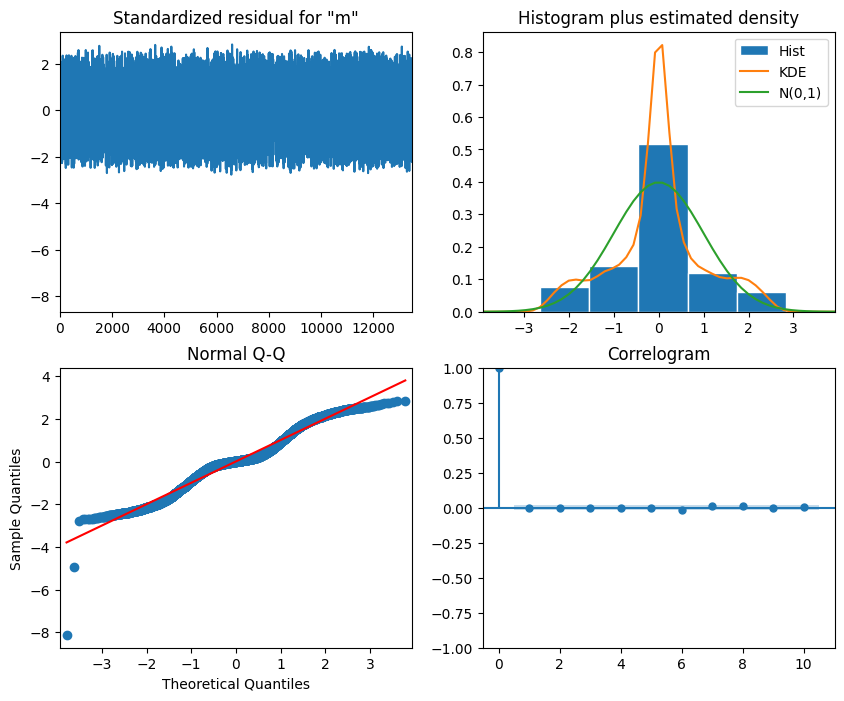

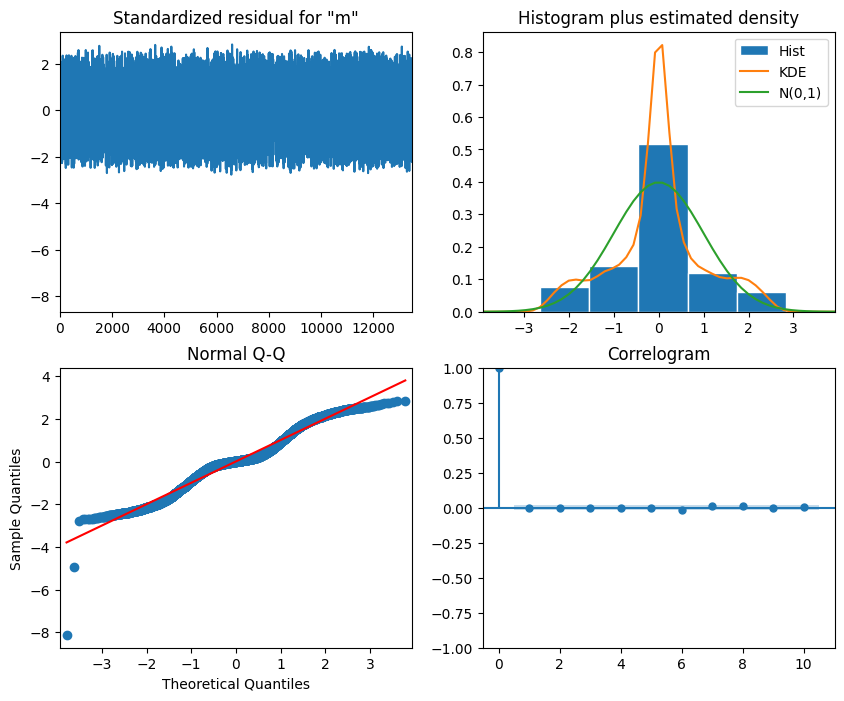

In [155]:
model_fit.plot_diagnostics(figsize=(10,8))

In [156]:
ARIMA_pred = model_fit.get_prediction(13485, 16856).predicted_mean

In [157]:
pred = pd.DataFrame(ARIMA_pred)
df1 = test.reset_index(drop=True)
df2 = pred.reset_index(drop=True)

df1['predicted_mean'] = df2['predicted_mean'].values

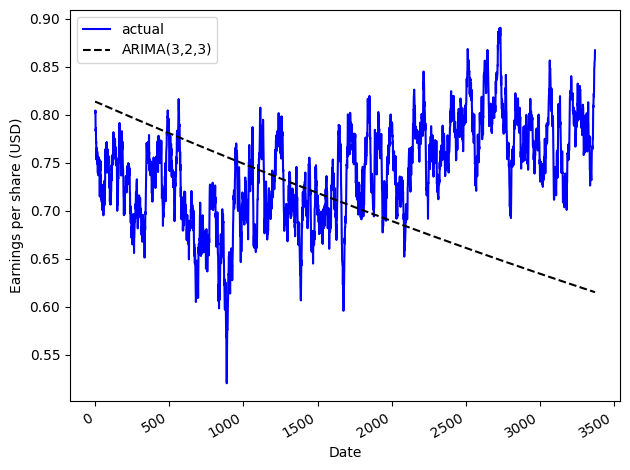

In [159]:
fig, ax = plt.subplots()

ax.plot(df1['moving_average_pos'], 'b-', label='actual')
ax.plot(df1['predicted_mean'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [161]:
# True values and predicted values
y_true = df1['moving_average_pos']
y_pred = df1['predicted_mean']

# Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Display results
print(f"R² Score  : {r2:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"MSE       : {mse:.4f}")
print(f"RMSE      : {rmse:.4f}")

R² Score  : -2.7707
MAE       : 0.0841
MSE       : 0.0100
RMSE      : 0.1001


# Neutral Sentiment

In [170]:
train = new_df[['timestamp', 'moving_average_neu']][:int(0.8 * len(new_df))]
test = new_df[['timestamp', 'moving_average_neu']][int(0.8 * len(new_df)):]

In [171]:
train.set_index('timestamp', inplace=True)
test.set_index('timestamp', inplace=True)

In [172]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(2, 0)",-103448.237118
1,"(1, 1)",-103447.869263
2,"(2, 1)",-103447.515512
3,"(3, 0)",-103447.120817
4,"(1, 2)",-103446.980195
5,"(2, 3)",-103445.717466
6,"(1, 3)",-103445.299712
7,"(3, 1)",-103444.753895
8,"(3, 2)",-103434.569550
9,"(1, 0)",-103429.587473


In [173]:
model = SARIMAX(train, order=(2,0,0), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     moving_average_neu   No. Observations:                13485
Model:               SARIMAX(2, 0, 0)   Log Likelihood               51727.119
Date:                Sat, 10 May 2025   AIC                        -103448.237
Time:                        20:05:17   BIC                        -103425.709
Sample:                             0   HQIC                       -103440.723
                              - 13485                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0379      0.008    122.390      0.000       1.021       1.054
ar.L2         -0.0391      0.008     -4.614      0.000      -0.056      -0.023
sigma2      2.726e-05    2.6e-07    104.903      0.0

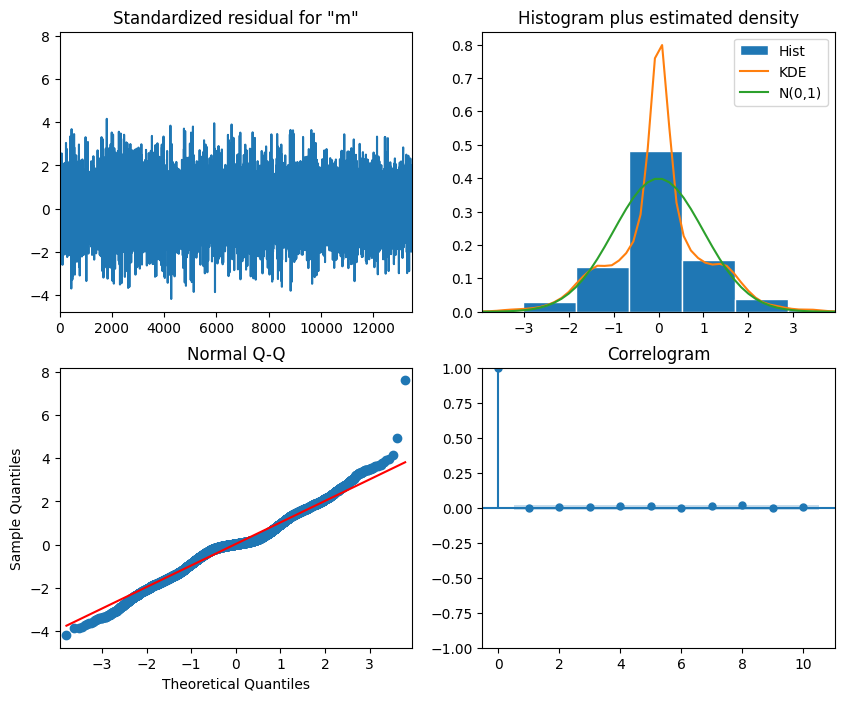

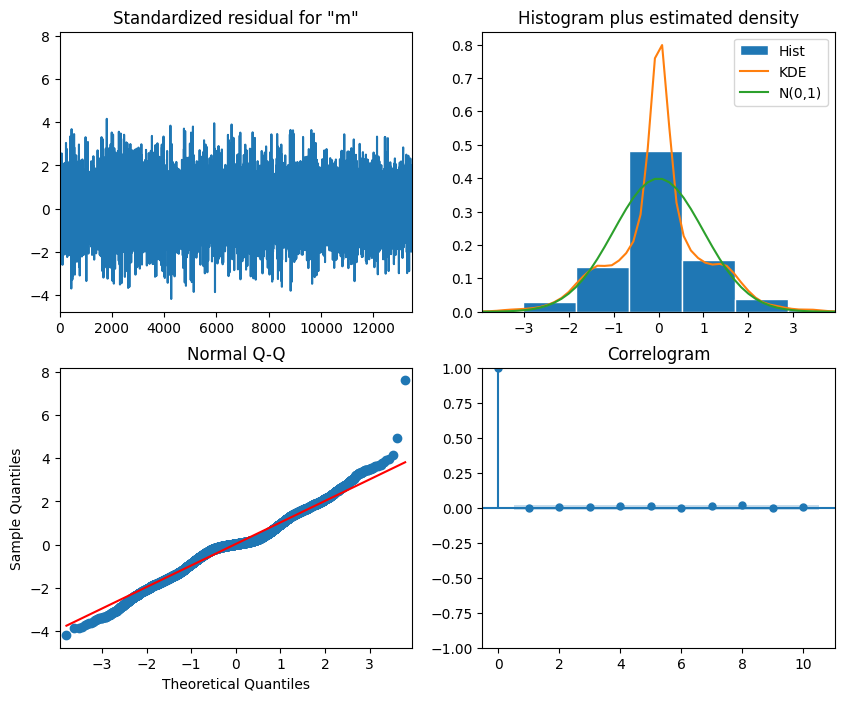

In [174]:
model_fit.plot_diagnostics(figsize=(10,8))

In [175]:
ARIMA_pred = model_fit.get_prediction(13485, 16856).predicted_mean

In [177]:
pred = pd.DataFrame(ARIMA_pred)
df1 = test.reset_index(drop=True)
df2 = pred.reset_index(drop=True)

df1['predicted_mean'] = df2['predicted_mean'].values

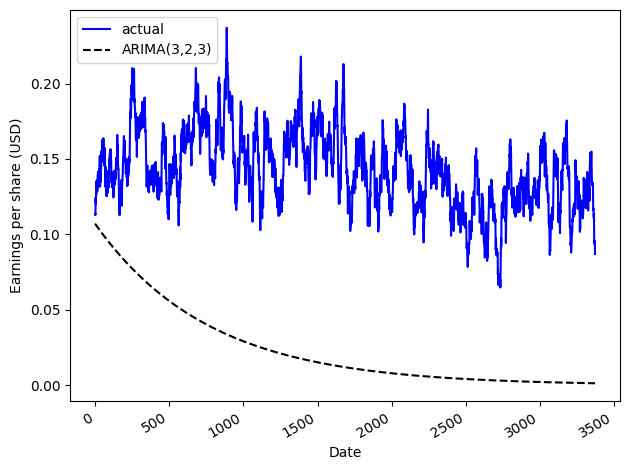

In [178]:
fig, ax = plt.subplots()

ax.plot(df1['moving_average_neu'], 'b-', label='actual')
ax.plot(df1['predicted_mean'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [180]:
# True values and predicted values
y_true = df1['moving_average_neu']
y_pred = df1['predicted_mean']

# Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Display results
print(f"R² Score  : {r2:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"MSE       : {mse:.4f}")
print(f"RMSE      : {rmse:.4f}")

R² Score  : -23.0561
MAE       : 0.1188
MSE       : 0.0151
RMSE      : 0.1228
